# Welcome to dymoval's tutorial!
 
In this tutorial we show the main functionalities of *dymoval*.

### Problem formulation
We assume that we built the model of a DC electric motor that we want to validate.
The dynamics of the actual DC motor that we want to capture are the connections between the input DC voltage and the motor speed, the DC current and the rotation angle that are considered as *outputs*.

### Validation setup
To validate our model we need to verify that its response is as close as possible to the actual DC motor response in front of the same *input* signal. Therefore, we need some **log data** and a **model**.
We assume that we get some logs from the labs where a team run some experiments and collected the results in a HDF5 file and that another team developed a DC motor model. 


## Measurement dataset
We first need to build a *dymoval* Dataset object from the HDF5 file that we received. 

Let's import some useful packages

In [1]:
import dymoval as dmv
import numpy as np
import matplotlib.pyplot as plt
import h5py
from copy import deepcopy
from itertools import product

Then, let's read the log data stored in the hdf5 file. All the logs that we are interested in are stored in the group "signals".
Feel free to explore the hdf5 file at your convenience.
In this example, we use the h5py package to read it, but feel free to explore any other package that can read HDF5 files.

In [2]:
logs = h5py.File('./ElMotorLogs.h5', 'r')
logs["signals"].keys()

<KeysViewHDF5 ['V', 'dot_theta', 'ia', 'theta']>

We can extract the logged signals as it follows (see h5py docs for more info)

In [3]:
V = logs["signals/V"]
ia = logs["signals/ia"]
theta = logs["signals/theta"]
dot_theta = logs["signals/dot_theta"]

At this point we can cast the logs into *dymoval* `Signal`s. 
Dymoval's *Signal*s are utility Python *dict* (in reality they are *Typeddict*) used to represent signals. 

In [4]:
signal_list = []
for val in [V,ia,theta,dot_theta]:
    temp:dmv.Signal={
        "name" : val.attrs["name"].decode('utf-8'),
        "values" : val[:],
        "signal_unit" : val.attrs["unit"].decode('utf-8'),
        "sampling_period" : val.attrs["period"][0],
        "time_unit" : val.attrs["sampling_unit"].decode('utf-8'),
    }
    signal_list.append(deepcopy(temp))


... and we can take a look at them. 

(<Figure size 640x480 with 4 Axes>, <numpy.flatiter at 0x1f4a71a6c10>)

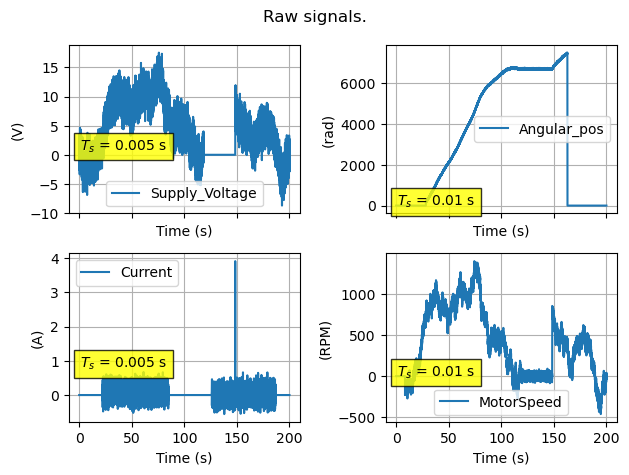

In [5]:
dmv.plot_signals(*signal_list)

As we can see, the signals have not been logged with the same sampling period and there is also some missing data.

A sound dataset shall have all the signals sampled with the same sampling period and it should not contains missing data. 
However, we can trim the signals in the time range e.g. $T = [25,80]\,s$ which seems a portion where no signal is missing data.

Finally, we can separate input and output signals and we can attempt to re-sample all of them with target sampling period equal to $0.01\,s$

In [6]:
signal_names = [s["name"] for s in signal_list]
u_names = signal_names[0]
y_names = signal_names[1:]
ds = dmv.Dataset(
    "ElMotor",
    signal_list,
    u_names,
    y_names,
    target_sampling_period=0.01,
    tin = 25.0,
    tout = 80.0,
)

> If you are in interactive mode, then you don't need to pass the arguments `tin` and `tout` but you can resize the figure graphically. The values of `tin` and `tout` will be automatically set when the figure is closed. 

When creating a *Dataset* object, the signals are always re-sampled in such a way that all of them will have the same sampling period, but sometimes this is not possible and therefore some signals may be excluded from the Dataset. 

The list of the excluded signals are stored in the attibute `excluded_signal`.

In [7]:
ds.excluded_signals

[]

As you can see, in this example all the signals have been correctly re-sampled and therefore there are no excluded signals.

Let's now take a look at how our Dataset looks like. 

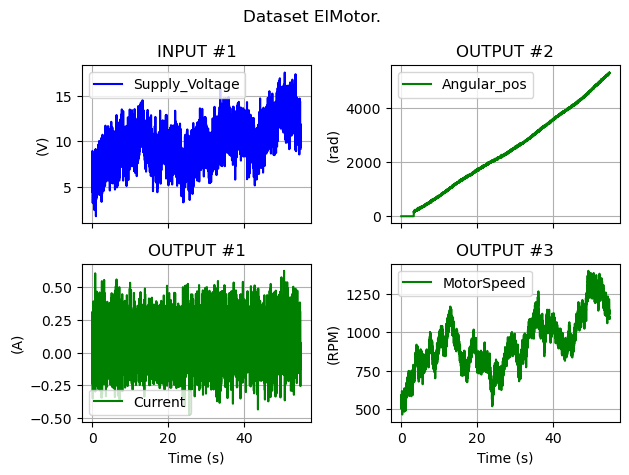

In [8]:
ds.plot()

...and let's check its coverage.

(<numpy.flatiter at 0x1f4a71ab600>, <numpy.flatiter at 0x1f4a71a8130>)

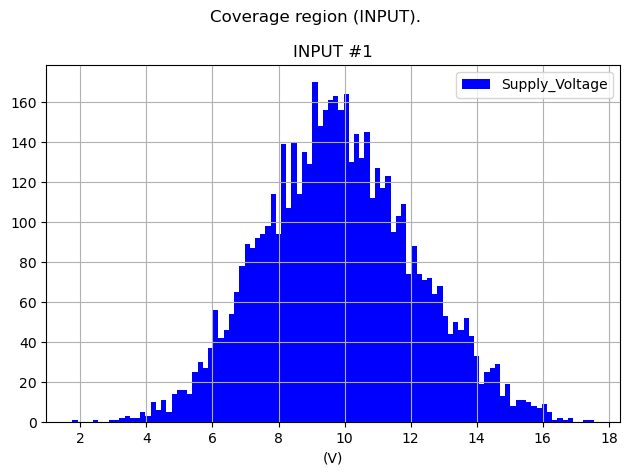

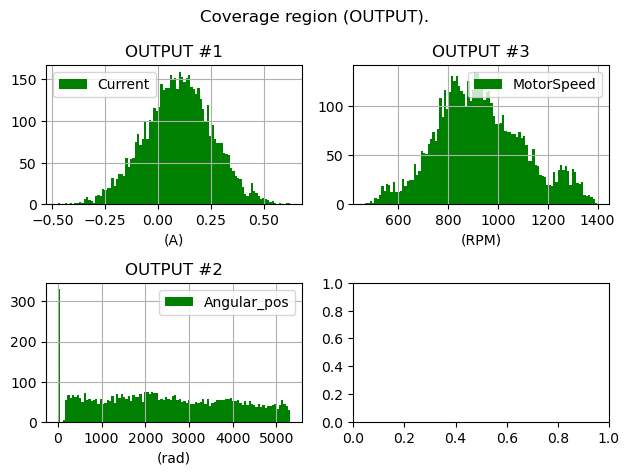

In [9]:
ds.plot_coverage()

As seen from the plot, the measurements are a bit noisy, so we may want to clean them up a little bit through a low pass filter.

However, we should find where to place the filter cutoff frequencies, and therefore it could be helpful to make a spectral analysis. 

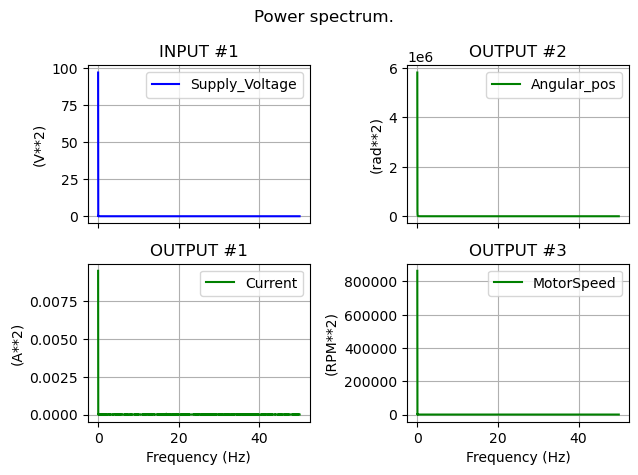

In [10]:
ds.plot_spectrum()

As seen, all of the signals bandwidth is in contained a narrow range $f < 5\, Hz$. Therefore, we may want to low pass filter all the signal at $f_c = 2.5\, Hz$. 

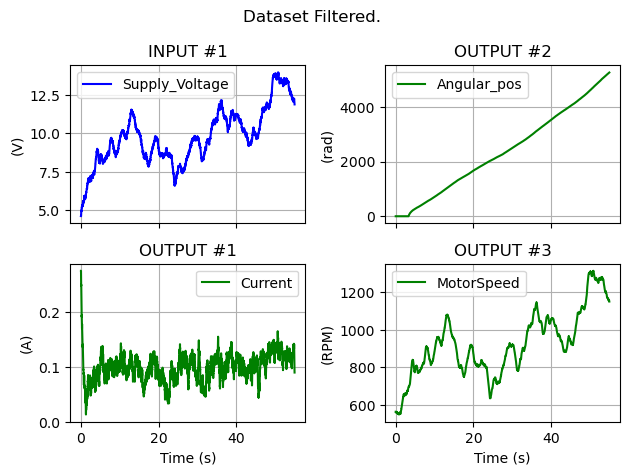

In [11]:
cutoff = 2.5  # [Hz]
signal_names = [s[1] for s in ds.signal_list()]
filter_bank = list(product(signal_names,[cutoff]))
ds_filt = ds.low_pass_filter(*filter_bank)
ds_filt.name = "Filtered"
ds_filt.plot()

As seen, the noise has gone. 
We can compare our datasets before and after the filtering. 

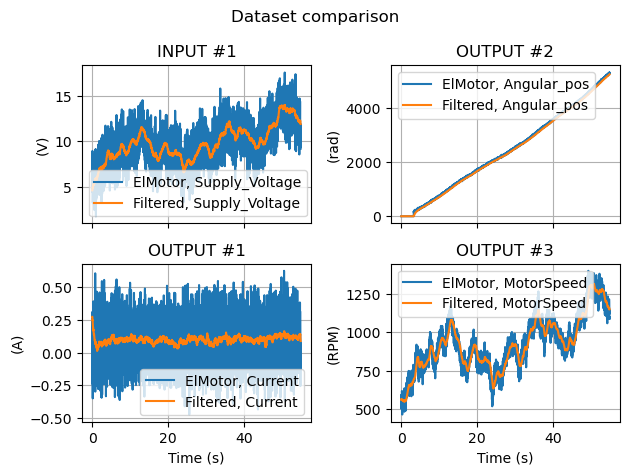

In [12]:
dmv.compare_datasets(ds,ds_filt)

We can also compare the coverage regions and the frequency response. 

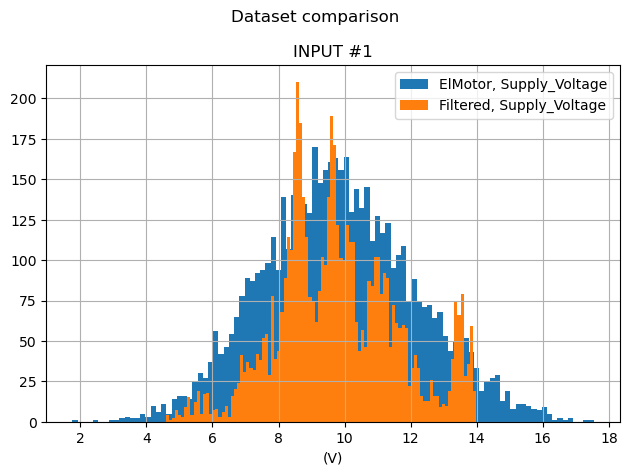

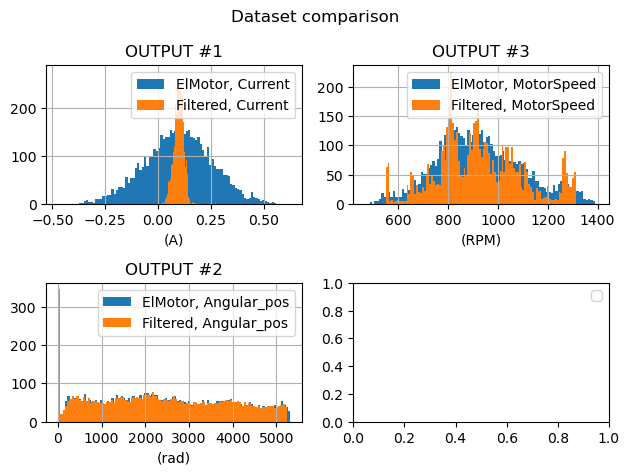

In [13]:
dmv.compare_datasets(ds,ds_filt, kind="coverage")

For each dataset, we can also see the coverage statistics in terms of mean value and covariance matrix

In [14]:
mean_in, cov_in, mean_out, cov_out = ds.coverage
mean_out

names        units
Current      A           0.0974
Angular_pos  rad      2408.7492
MotorSpeed   RPM       929.3003
dtype: float64

In [15]:
cov_out

,names,Current,Angular_pos,MotorSpeed
,units,A,rad,RPM
names,units,,,
Current,A,0.0256,1.552360e+01,2.6797
Angular_pos,rad,15.5236,2.327087e+06,197320.5043
MotorSpeed,RPM,2.6797,1.973205e+05,31113.2013


We can play around with Dataset objects with many other functions. 
See *dymoval*'s documentation to discover more.

## Validation Session

Now that we have a "cleaned-up" Dataset, we can validate our model.

First, we need to create a *ValidationSession* object from out Dataset object. 

In [16]:
vs = dmv.ValidationSession("DCMotor_val", ds_filt)

At this point, it is enough to simulate our model with the same input (which in our case is the logged voltage profile) stored in `ds_filt`. 
First, we extract the numerical values of the input signal from the dataset.

In [17]:
(t,u,y) = vs.Dataset.dataset_values()

Then, we load our model and we feed it with such an input `u` and we store the model response to a variable `y_sim`

>Note that it is not required that you run model within Python, nor the model to have a specific format. You just need to import the  simulation results of your model that you may have simulated elsewhere and append such simulation results to a  *dymoval* ValidationSession object. 

In [1]:
from  DCMotorModel import DCMotor_dt
from scipy import signal

# Simulate model
_, y_sim,_  = signal.dlsim(DCMotor_dt, u,t)


DC motor model loaded, sampling time Ts = 0.01.


NameError: name 'u' is not defined

Next, we append the simulation results to the *ValidationSession* object `vs`. To do that, we need to give a label to the simulation and we shall also give a name to the output signals from the simulation. 

In [19]:
# Append simulation
sim_name = "DCMotor_ss_model"
sim_labels = ["ia","theta","dot_theta"]
vs = vs.append_simulation(sim_name, sim_labels, y_sim)

At this point we can compare the output of our model with the Dataset to have a first idea on how good our model is

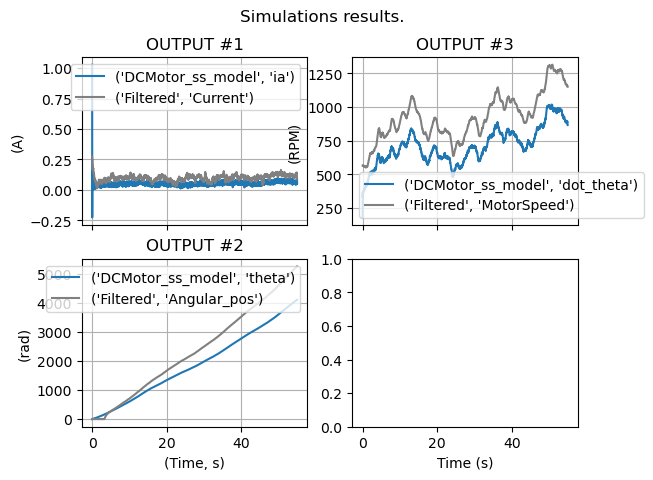

In [20]:
_=vs.plot_simulations(dataset='out')

Our model does not look too bad! 
But let's take a look at the validation metrics (which are just an attribute of the *ValidationSession* objects)

In [21]:
vs.validation_results

,DCMotor_ss_model
r-square (%),82.9311
Residuals Auto-corr,1.7553
Input-Res. Cross-corr,1.2360


The r-square fit looks not bad, but the residuals are a bit high. 
Let's take a visual inspection of them.  

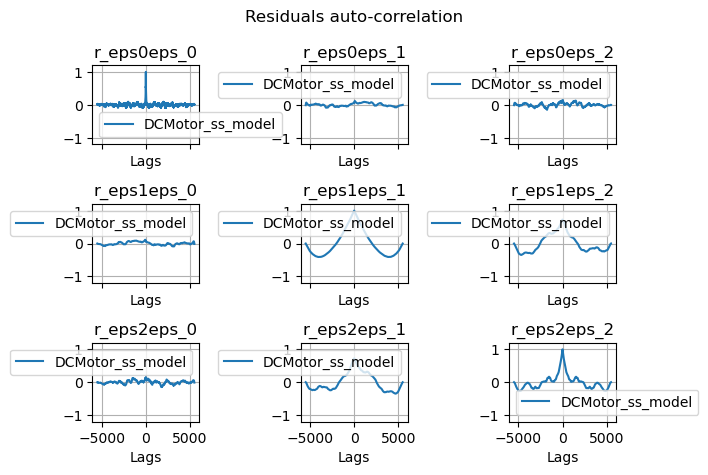

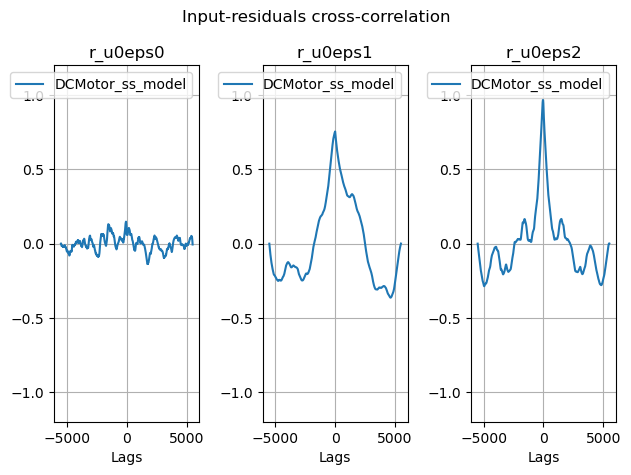

In [22]:
_ = vs.plot_residuals()

As we can see, the residuals auto-correlation is not too bad, but the input-residuals strongly depends on the input - especially the voltage - rotation angle and the the voltage - motor speed residuals. 
To be sure of the results we could perhaps try with another dataset.
Anyways, high values of the input-output residuals means that there is magin of improvements of our model, especially for the input-output part.

Finally, Keep in mind that these results are valid only in the coverage region of the model! 

## TO DO 

Try with FMU:s and write few final notes.

In [23]:
# import fmpy

#fmpy.dump('ElMotor.fmu')

In [24]:
#output = [s[1] for s in vs.Dataset.signal_list() if s[0] == "OUTPUT"]
#output

In [25]:
#model_description = fmpy.read_model_description('ElMotor.fmu')
#vrs = {}
#for variable in model_description.modelVariables:
#    vrs[variable.name] = variable.valueReference
#vrs

In [26]:
#result = fmpy.simulate_fmu(
#        filename='ElMotor.fmu',
#        start_time=0,
#        stop_time=200,
#        output = output,
#        input=u,)

Note that the *Dataset* object `ds_filt` is now an attribute of the *ValidationSession* object `vs`.
This means that you can access all the methods and attributes of the *Dataset* object `ds_filt` directly from the *ValidationSession* object `vs`.

In [27]:
ds.dataset

kind               INPUT  OUTPUT                       
names     Supply_Voltage Current Angular_pos MotorSpeed
units                  V       A         rad        RPM
(Time, s)                                              
0.00              4.5868  0.2745      0.0000   564.9741
0.01              4.4167 -0.1502      0.0000   504.2730
0.02              5.6044 -0.0288      0.0000   525.6572
0.03              8.9338 -0.0251      0.0000   546.9950
0.04              7.4720  0.1475      0.0000   579.3100
...                  ...     ...         ...        ...
54.96            11.4183 -0.0719   5298.4540  1102.3113
54.97             9.6703 -0.0801   5278.8887  1101.5421
54.98             9.8815 -0.0086   5311.7920  1090.0945
54.99            11.6435 -0.0065   5320.0918  1099.0003
55.00             9.1828 -0.0435   5307.7322  1087.6216

[5501 rows x 4 columns]